### Newton Voters geocoding

In [1]:
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from utils.time import convert_to_datetime
from utils.data import contains_text
from math import floor
import warnings
import gender_guesser.detector as gender

warnings.filterwarnings("ignore")
%load_ext jupyter_black


Newton Shapefiles accessed through
https://github.com/NewtonMAGIS/GISData
GeoJSON data rare in WGS84, per the github

Voter data provided by the Newton City Clerk's office

Massachusetts party affilitation information: https://en.wikipedia.org/wiki/Political_parties_and_political_designations_in_Massachusetts


In [2]:
RESIDENTS = (
    "/Volumes/T5_External/data/newton/2025.06.06_RESIDENT EXTRACT_207RES_336727.csv"
)
VOTERS = "/Volumes/T5_External/data/newton/2025.06.06_VOTER EXTRACT.csv"
STREETS = (
    "/Volumes/T5_External/data/newton/map/GISData/Streets/StreetCenterLines.geojson"
)
ADDRESSES = "/Volumes/T5_External/data/newton/map/GISData/Addresses/Addresses.geojson"
WARDS = (
    "/Volumes/T5_External/data/newton/map/GISData/Wards and Precincts/Precincts.geojson"
)
POLLING = "/Volumes/T5_External/data/newton/map/GISData/Polling Locations/PollingLocations.geojson"
BUILDINGS = "/Volumes/T5_External/data/newton/map/GISData/Buildings/Buildings.geojson"
PARTIES = "/Volumes/T5_External/data/newton/massachusetts_voter_affiliations.csv"

In [3]:
# get all residents data
residents_df = pd.read_csv(RESIDENTS, low_memory=False, index_col=[0])
residents_df.columns = [
    x.lower().strip().replace(" ", "_").replace("-", "").replace("__", "_")
    for x in residents_df.columns.values
]

# get voter data (subset of residnets)
voter_df = pd.read_csv(VOTERS, low_memory=False, index_col=[0])
voter_df.columns = [
    x.lower().strip().replace(" ", "_").replace("-", "").replace("__", "_")
    for x in voter_df.columns.values
]

# add nationality and occupation to voter data (from residents), when available
voter_df = voter_df.merge(
    residents_df[["resident_id_number", "occupation", "nationality"]],
    left_on=["voter_id_number"],
    right_on=["resident_id_number"],
    how="left",
)

In [4]:
# add spelled out party definitions
party_df = pd.read_csv(PARTIES)
voter_df["party_affiliation"] = [x.strip() for x in voter_df.party_affiliation]
voter_df = voter_df.merge(
    party_df, left_on="party_affiliation", right_on=["ma_abbreviation"], how="left"
)

liberal = [
    "Democratic Party",
    "Green Party USA",
    "Green-Rainbow Party",
    "Latino-Vote Party",
    "New Alliance Party",
    "Pirate",
    "Rainbow Coalition",
    "Socialist",
    "People's Party",
    "Workers Party",
    "Working Families",
]
conservative = [
    "Republican Party",
    "Libertarian",
    "America First Party",
    "American Independent Party",
    "American Term Limits",
    "Conservative Party",
    "Constitution Party",
    "Prohibition Party",
    "Reform Party",
    "Veterans Party America",
]

voter_df["politics"] = "middle/unknown"
voter_df["politics"] = [
    "right" if x in conservative else v
    for x, v in zip(voter_df.party_name, voter_df.politics)
]
voter_df["politics"] = [
    "left" if x in liberal else v
    for x, v in zip(voter_df.party_name, voter_df.politics)
]

In [5]:
# get address spatial info
address_gdf = gpd.read_file(ADDRESSES)
address_gdf.columns = [
    x.lower().strip().replace(" ", "_").replace("-", "").replace("__", "_")
    for x in address_gdf.columns.values
]

# fill in nan data for merging
address_gdf.streetname.fillna(" ", inplace=True)
address_gdf.posttype.fillna(" ", inplace=True)
address_gdf["full_street"] = [
    n + " " + p for n, p in zip(address_gdf.streetname, address_gdf.posttype)
]
# get buildling data
buildings_gdf = gpd.read_file(BUILDINGS)
buildings_gdf.columns = [
    x.lower().strip().replace(" ", "_").replace("-", "").replace("__", "_")
    for x in buildings_gdf.columns.values
]
# merge with building type
address_gdf = address_gdf.merge(
    buildings_gdf[["ownership", "complex", "addressid", "shape_area", "labeltext"]],
    on="addressid",
)
# subset to just residential
residential_gdf = address_gdf.loc[address_gdf.addresstype == "Residential"]

In [6]:
# merge voter data with residential address geodataframe: make voter geodataframe
voter_basic_gdf = gpd.GeoDataFrame(
    voter_df.merge(
        residential_gdf[
            [
                "number",
                "fullstname",
                "streetname",
                "full_street",
                "addressid",
                "source",
                "status",
                "locationtype",
                "complex",  # for names of complex gives name
                "ownership",  # most are private ... a few others
                "labeltext",  # gives indication if a multifamily
                "shape_area",  # buildling area
                "geometry",
            ]
        ].drop_duplicates(),
        left_on=[
            "residential_address_street_number",
            "residential_address_street_name",
        ],
        right_on=["number", "fullstname"],
        how="left",
    ),
    geometry="geometry",
)

In [7]:
# Merge with ward and precinct info
ward_gdf = gpd.read_file(WARDS)
ward_gdf.columns = [x.lower() for x in ward_gdf]
voter_ward_gdf = gpd.sjoin(voter_basic_gdf, ward_gdf, predicate="within")

In [8]:
# add polling place
polling_gdf = gpd.read_file(POLLING)
polling_gdf.columns = ["polling_" + x.lower() for x in polling_gdf.columns.values]
voter_gdf = voter_ward_gdf.merge(polling_gdf, left_on="wp", right_on="polling_precinct")

In [9]:
# identify uber rich

# multifamily
for c in ["labeltext", "residential_address_apartment_number"]:
    voter_gdf[c] = voter_gdf[c].fillna("")

voter_gdf["multifamily"] = [
    1 if ("-" in x) | (a != "") | ((c != "") & (c != " ")) else 0
    for x, a, c in zip(
        voter_gdf.labeltext,
        voter_gdf.residential_address_apartment_number,
        voter_gdf.complex,
    )
]
voter_gdf["big_single_family"] = [
    1 if (m == 0) & (a > 2735.7) & (own == "Private") else 0
    for m, a, own in zip(
        voter_gdf.multifamily, voter_gdf.shape_area, voter_gdf.ownership
    )
]

In [10]:
street_gdf = gpd.read_file(STREETS)

In [11]:
# voter_gdf = gpd.read_file("~/Desktop/voters.geojson")

In [12]:
voter_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47838 entries, 0 to 47837
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   voter_id_number                           47838 non-null  object  
 1   last_name                                 47836 non-null  object  
 2   first_name                                47836 non-null  object  
 3   middle_name                               35373 non-null  object  
 4   title                                     676 non-null    object  
 5   residential_address_street_number         47838 non-null  int64   
 6   residential_address_street_suffix         491 non-null    object  
 7   residential_address_street_name           47838 non-null  object  
 8   residential_address_apartment_number      47838 non-null  object  
 9   residential_address_zip_code              47838 non-null  object  
 10  mailing_addres

<Axes: >

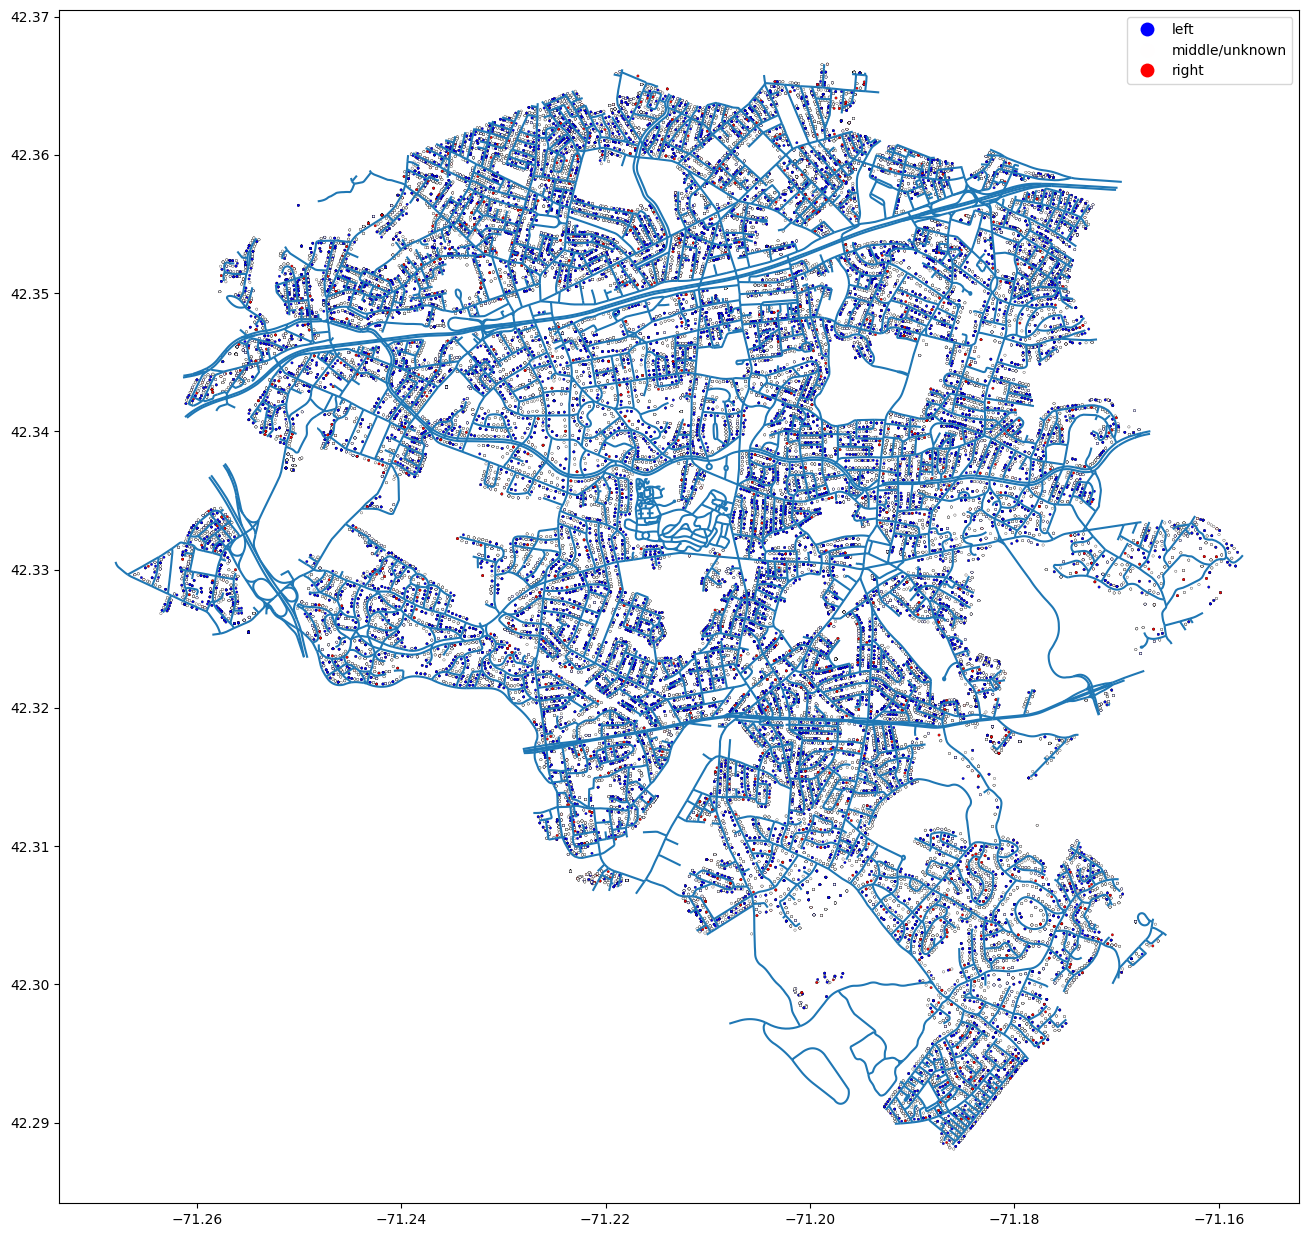

In [13]:
voter_gdf.fillna("", inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
street_gdf.plot(ax=ax)
voter_gdf.plot(
    ax=ax,
    column="politics",
    cmap="bwr",
    markersize=3,
    edgecolor="k",
    lw=0.2,
    legend=True,
)

In [14]:
# Get the lat and lon for plotly/dash
voter_gdf["lat"] = voter_gdf["geometry"].y
voter_gdf["lon"] = voter_gdf["geometry"].x

In [15]:
# combine fields for easier data access
for c in ["number", "fullstname", "first_name", "last_name"]:
    voter_gdf[c].fillna(" ", inplace=True)

voter_gdf["address"] = [
    str(int(n)) + " " + s for n, s in zip(voter_gdf["number"], voter_gdf["fullstname"])
]
voter_gdf["fullname"] = [
    f + " " + l for f, l in zip(voter_gdf["first_name"], voter_gdf["last_name"])
]

In [16]:
# get age on election day

voter_gdf["age_on_election_day"] = [
    (
        (
            dt.datetime(2025, 11, 4) - convert_to_datetime(x, fmt="%m/%d/%y")
        ).total_seconds()
        / (365.25 * 24 * 60 * 60)
    )
    for x in voter_gdf.date_of_birth
]

voter_gdf["age_on_election_day"] = voter_gdf["age_on_election_day"].apply(floor)
# make hacky correction to the less-than-0 ages, which we assume are actually just two-digit year errors (note this doesn't actualy solve the problem)
voter_gdf["age_on_election_day"] = [
    100 + a if a <= 0 else a for a in voter_gdf["age_on_election_day"]
]

In [17]:
voter_gdf.occupation.fillna("", inplace=True)
education_professions = [
    "educator",
    "school",
    "teacher",
    "professor",
    "instructor",
    "principal",
]
helping_professions = [
    "social",
    "soc service",
    "nurse",
    "counselor",
    "police",
    "fire",
    "clergy",
    "nun",
]
finance_professions = [
    "finance",
    "financial",
    "broker",
    "stock trader",
    "capital",
    "equity",
    "cfo",
    "private",
]
muckity_mucks = ["executive", "president", "chairman", "ceo", "CHIEF EXEC OFF"]

voter_gdf["educator"] = [
    (1 if contains_text(x, education_professions) else 0) for x in voter_gdf.occupation
]

voter_gdf["helping"] = [
    (1 if contains_text(x, helping_professions) else 0) for x in voter_gdf.occupation
]
voter_gdf["finance"] = [
    (1 if contains_text(x, finance_professions) else 0) for x in voter_gdf.occupation
]
voter_gdf["muckity_muck"] = [
    (1 if contains_text(x, muckity_mucks) else 0) for x in voter_gdf.occupation
]

In [18]:
# get voter gender
voter_gdf.first_name.fillna("", inplace=True)
d = gender.Detector()
voter_gdf["gender"] = [d.get_gender(x.title()) for x in voter_gdf.first_name]

In [19]:
voter_gdf["men_over_60"] = [
    1 if (a > 60) & (g == "male") else 0
    for a, g in zip(voter_gdf.age_on_election_day, voter_gdf.gender)
]
voter_gdf["women"] = [
    1 if (g == "female") | (g == "mostly_female") else 0 for g in voter_gdf.gender
]

In [26]:
voter_gdf["wp_address_id"]

0         3415996564
1         8114926777
2        82159867156
3          211178606
4         2123266023
            ...     
47833     6314006118
47834     8223775957
47835     1319865811
47836     1320255824
47837     3320926510
Name: wp_address_id, Length: 47838, dtype: object

In [21]:
voter_gdf["wp_address_id"] = [
    f"{w}{p}{a}"
    for w, p, a in zip(voter_gdf.ward, voter_gdf.precinct, voter_gdf.addressid)
]

In [22]:
voter_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47838 entries, 0 to 47837
Data columns (total 69 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   voter_id_number                           47838 non-null  object  
 1   last_name                                 47838 non-null  object  
 2   first_name                                47838 non-null  object  
 3   middle_name                               47838 non-null  object  
 4   title                                     47838 non-null  object  
 5   residential_address_street_number         47838 non-null  int64   
 6   residential_address_street_suffix         47838 non-null  object  
 7   residential_address_street_name           47838 non-null  object  
 8   residential_address_apartment_number      47838 non-null  object  
 9   residential_address_zip_code              47838 non-null  object  
 10  mailing_addres

In [23]:
voter_gdf.rename(
    columns={"residential_address_apartment_number": "apt"},
    inplace=True,
)

## Write out

In [24]:
voter_gdf = voter_gdf[
    [
        "addressid",
        "wp_address_id",
        "voter_id_number",
        "fullname",
        "first_name",
        "number",
        "address",
        "fullstname",
        "apt",
        "party_affiliation",
        "age_on_election_day",
        "ward",
        "precinct",
        "occupation",
        "nationality",
        "party_name",
        "politics",
        "polling_location",
        "big_single_family",
        "educator",
        "finance",
        "muckity_muck",
        "helping",
        "multifamily",
        "men_over_60",
        "women",
        "gender",
        "geometry",
        "lat",
        "lon",
    ]
]

In [ ]:
voter_gdf.iloc[0]

In [ ]:
#voter_gdf = gpd.read_file("~/Desktop/voters.geojson")

In [ ]:
voter_gdf.drop("geometry", axis=1).to_csv("~/Desktop/voters.csv")
voter_gdf.to_file("~/Desktop/voters.geojson")

In [ ]:
voter_gdf[["vp" in x.lower() for x in voter_gdf.occupation]].gender.value_counts()

In [ ]:
voter_gdf.loc[voter_gdf.gender == "mostly_female"].first_name

In [ ]:
list(voter_gdf.loc[voter_gdf.politics == "left"].occupation.unique())